## Objectives

Object Detection in YOLO

## Import libararies

In [ ]:
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
# remove grid lines
import numpy as np
import time
import cv2
# import zipfile
from collections import namedtuple
import time
import os
from google.colab.patches import cv2_imshow


### Download images

In [ ]:
!wget https://www.dropbox.com/s/zkuva2h7c2lgub0/baggage_claim.jpg?dl=0 -O baggage_claim.jpg
!wget https://www.dropbox.com/s/uw9t17j9aa67fgz/2012_000160.jpg?dl=0 -O 2012_000160.jpg
!wget https://www.dropbox.com/s/2nmzpds3uzbanem/traffic.jpeg?dl=0 -O traffic.jpeg

--2024-10-15 20:41:32--  https://www.dropbox.com/s/zkuva2h7c2lgub0/baggage_claim.jpg?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/n576w2isa5qkygwprzjzq/baggage_claim.jpg?rlkey=diqtadal2i9pugq5rlkrtmj83&dl=0 [following]
--2024-10-15 20:41:32--  https://www.dropbox.com/scl/fi/n576w2isa5qkygwprzjzq/baggage_claim.jpg?rlkey=diqtadal2i9pugq5rlkrtmj83&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc32ff0e06ae6320f163d65bca00.dl.dropboxusercontent.com/cd/0/inline/CciJW-y5G1fPU8I8OAvLsRw_eKgh562r3hN9PhHLms0S5nTjyPbp3EKF8w8VU-f3TSIGtT_ygdOhfp_70lNvDw0XnySQh3o3y8SeTbE9xTVbNz_MqyShR_MsodU9UkZrIejzjrj9BQ8KxuvU1wFAO7IL/file# [following]
--2024-10-15 20:41:33--  https://uc32ff0e06ae6320f163d65bca00.dl.dropbo

### Download YOLO model

In [ ]:
!wget https://www.dropbox.com/s/1ke9p0wxdxtv29q/yolo-coco-model.zip?dl=0 -O yolo-object-model.zip
clear_output()

### Download Pascal dataset

In [ ]:
# !wget http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar -O pascal.tar -O pascal.tar
# clear_output()

### Extract model

In [ ]:
!unzip '/content/yolo-object-model.zip'

Archive:  /content/yolo-object-model.zip
   creating: yolo-coco-model/
  inflating: yolo-coco-model/yolov3.weights  
  inflating: yolo-coco-model/coco.names  
  inflating: yolo-coco-model/yolov3.cfg  


## IoU

In [ ]:
def IoU(box1, box2):
  """
  x1,y1 - coordinate of the left upper corner
  x2, y2 - coordinates of the right lower corner-
  box1: [x1,y1,x2,y2] coordinates of the ground truth box
  box2: [x1,y1,x2,y2] coordinates of the predicted box
  return: IoU between two boxes if they are overlapping, 0 otherwise
  """
 # determine coordinates of the intersection
  left_x = max(box2[0], box1[0])
  top_y = max(box2[1], box1[1])
  right_x = min(box2[2], box1[2])
  bottom_y = min(box2[3], box1[3])

  # compute intersection area
  interArea = abs(max((right_x - left_x), 0) * max((bottom_y - top_y), 0))

  # compute the area of both the prediction and ground-truth
  ground_area = abs((box1[0] - box1[2]) * (box1[1] - box1[3]))
  predicted_area = abs((box2[0] - box2[2]) * (box2[1] - box2[3]))

  # compute the IoU
  return interArea / (ground_area + predicted_area - interArea)


## YOLO with OpenCV

In [ ]:
PATH_TO_IMAGE = '/content/baggage_claim.jpg'
PATH_TO_YOLO = '/content/yolo-coco-model'
CONFIDENCE = 0.5
THRESHOLD = 0.3

class YOLO:
  def __init__(self, PATH_TO_YOLO, CONFIDENCE, THRESHOLD):
    self.CONFIDENCE = CONFIDENCE
    self.THRESHOLD = THRESHOLD
    # load the COCO class labels our YOLO model was trained on
    labelsPath = os.path.sep.join([PATH_TO_YOLO, 'coco.names'])
    self.LABELS = open(labelsPath).read().strip().split("\n")

    # initialize a list of colors to represent each possible class label
    np.random.seed(42)
    self.COLORS = np.random.randint(0, 255, size=(len(self.LABELS), 3),	dtype="uint8")

    # derive the paths to the YOLO weights and model configuration
    weightsPath = os.path.sep.join([PATH_TO_YOLO, "yolov3.weights"])
    print(weightsPath)
    configPath = os.path.sep.join([PATH_TO_YOLO, "yolov3.cfg"])

    # load YOLO object detector trained on COCO dataset (80 classes)
    net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

    # determine only the *output* layer names that we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

    self.net = net
    self.ln = ln

  def forward(self, image):
    """
    feed an image to YOLO network, filter weak boxes,
    return boxes, confidence, class labels
    """
    (H, W) = image.shape[:2]
    # construct a blob from the input image and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes and
    # associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    self.net.setInput(blob)
    start = time.time()
    layerOutputs = self.net.forward(self.ln)
    end = time.time()

    print("[INFO] YOLO took {:.6f} seconds".format(end - start))

    # initialize our lists of detected bounding boxes, confidences, and
    # class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []

    # loop over each of the layer outputs
    for output in layerOutputs:
      # loop over each of the detections
      for detection in output:
        # extract the class ID and confidence
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        # filter out weak predictions
        if confidence > self.CONFIDENCE:
          # scale the bounding box coordinates back relative to the
          # size of the image, keeping in mind that YOLO actually
          # returns the center (x, y)-coordinates of the bounding
          # box followed by the boxes' width and height
          box = detection[0:4] * np.array([W, H, W, H])
          (centerX, centerY, width, height) = box.astype("int")

          # use the center (x, y)-coordinates to derive the top and
          # and left corner of the bounding box
          x = int(centerX - (width / 2))
          y = int(centerY + (height / 2))

          # update our list of bounding box coordinates, confidences,
          # and class IDs
          boxes.append([x, y, int(width), int(height)])
          confidences.append(float(confidence))
          classIDs.append(classID)

    self.boxes = np.array(boxes)
    self.confidences = np.array(confidences)
    self.classIDs = np.array(classIDs)

  def non_max_supression(self):
    """
    perform non-maximum supression over boxes
    """
    # can be done using cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE, THRESHOLD)
    idxs = np.argsort(-self.confidences)
    confidences = self.confidences[idxs]
    boxes = self.boxes[idxs]
    classIDs = self.classIDs[idxs]

    for i in range(len(boxes)):
      x,y,w,h = boxes[i][0],  boxes[i][1], boxes[i][2], boxes[i][3]
      box1 = [x, y, x+w, y+h]
      for j in range(i+1, len(boxes)):
        if classIDs[i] == classIDs[j]:
          # если у них одинаковые классы, вычисляем IoU между ними
          x,y,w,h = boxes[j][0], boxes[j][1], boxes[j][2], boxes[j][3]
          box2 = [x, y, x+w, y+h]
          if IoU(box1, box2) > self.THRESHOLD:
            confidences[j] = 0

    idxs = np.where(confidences>0)
    self.boxes = boxes[idxs]
    self.confidences = confidences[idxs]
    self.classIDs = classIDs[idxs]

  def detect(self, image):
    """
    detect objects, supress non maximums, draw boxes
    return image with boxes
    """
    self.forward(image)
    self.non_max_supression()

    # draw boxes
    for i in range(len(self.boxes)):
      # extract the bounding box coordinates
      (x, y) = (self.boxes[i][0], self.boxes[i][1])
      (w, h) = (self.boxes[i][2], self.boxes[i][3])

      # draw a bounding box rectangle and label on the image
      color = [int(c) for c in self.COLORS[self.classIDs[i]]]
      cv2.rectangle(image, (x, y), (x + w, y - h), color, 2)
      text = "{}: {:.4f}".format(yolo.LABELS[self.classIDs[i]], self.confidences[i])
      cv2.putText(image, text, (x, y - h - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return image


/content/yolo-coco-model/yolov3.weights
[INFO] YOLO took 4.255656 seconds


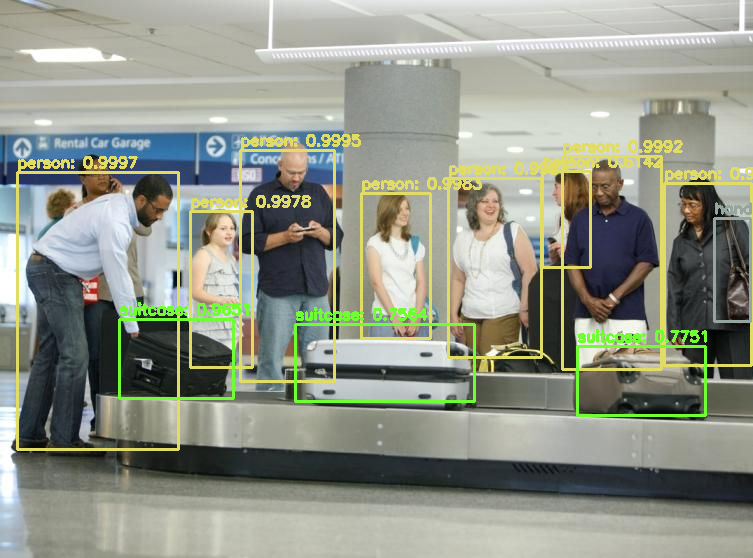

In [ ]:
yolo = YOLO(PATH_TO_YOLO, CONFIDENCE, THRESHOLD)
# load our input image and grab its spatial dimensions
image = cv2.imread(PATH_TO_IMAGE)
image = yolo.detect(image)
cv2_imshow(image)

[INFO] YOLO took 1.213811 seconds


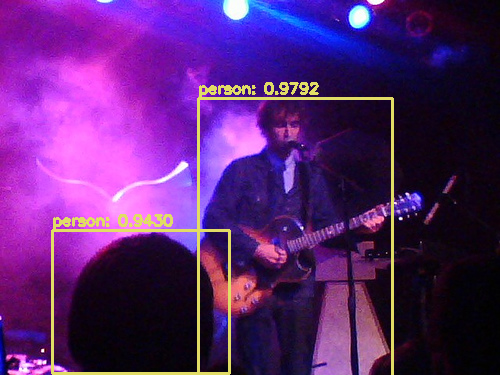

In [ ]:
image = cv2.imread('2012_000160.jpg')
image = yolo.detect(image)
cv2_imshow(image)

[INFO] YOLO took 1.204794 seconds


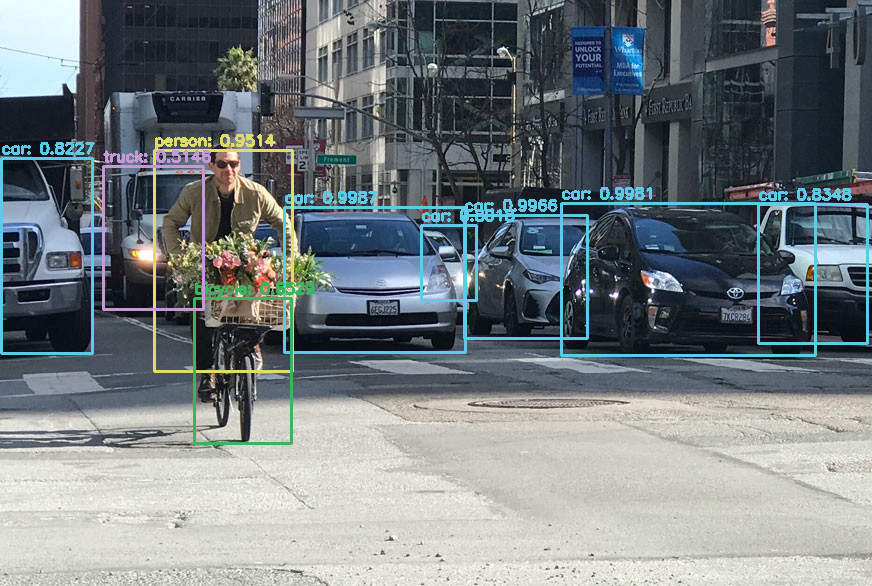

In [ ]:
image = cv2.imread('traffic.jpeg')
image = yolo.detect(image)
cv2_imshow(image)

## Test YOLO on an image from Pascal dataset

[INFO] YOLO took 1.271063 seconds


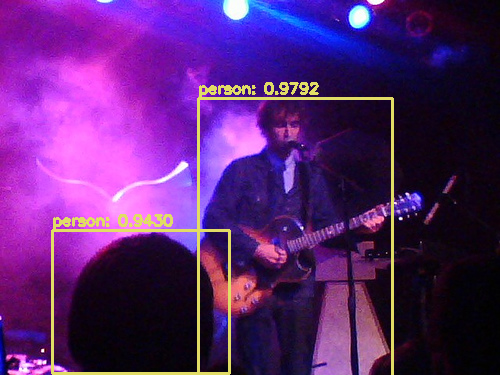

In [ ]:
image = cv2.imread('2012_000160.jpg')
image = yolo.detect(image)
cv2_imshow(image)

## References

Original YOLO paper [link](https://arxiv.org/pdf/1506.02640.pdf)

YOLOv2 paper [link](https://arxiv.org/pdf/1612.08242v1.pdf)

YOLO explained [link](https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088)

IoU [link](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

Non-Maximum Supression [link](https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/)

Overview of deep learning based object detection approaches [link](https://towardsdatascience.com/beginners-guide-to-object-detection-algorithms-6620fb31c375)

Mean Average Precision [link](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173)

